# Trabajo de aprendizaje activo

Manuel Bajo Buenestado y Kevin Craig Alisauskas

08-04-2019




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
#from al_base import ao
from sklearn.cluster import KMeans
from random import randint
from sklearn.utils import resample
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist
import random
random.seed(31415926535)

In [2]:
# se cargan los datos

# Unlabeled
U = pd.read_csv("./Datos/semeion_unlabeled.csv", header = None)
X_U = U.iloc[:,1:]
y_U = U.iloc[:,0]

# Test
test = pd.read_csv("./Datos/semeion_test.csv", header = None)
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

# Labeled
L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
X_L = L.iloc[:,1:]
y_L = L.iloc[:,0]


In [3]:

# Definimos la gamma en función de las muestras etiquetadas.
sigma = np.mean(pdist(X_L))
gamma = 1 / (2 * sigma * sigma)

# El modelo sera SVC (un clasificador usando support vector machines)
model = SVC(gamma = gamma, C = 100, probability=True, decision_function_shape = "ovr")


In [4]:

def MS(model, X_U, already_selected, N):

    distances = []

    # Para todas las distancias a todos los hiperplanos calculamos la media.
    for i in model.decision_function(X_U):
        distances.append(np.linalg.norm(i))

    distances = np.array(distances)
    rank_ind = np.argsort(distances)
    rank_ind = [i for i in rank_ind if i not in already_selected]
    active_samples = rank_ind[0:N]

    return active_samples, distances[active_samples]

def MCLU(model, X_U, already_selected, N):

    distances = []

    # Definimos las distancias a cada hiperplano
    distances = abs(model.decision_function(X_U))

    # Ordenamos las distancias de menor a mayor
    sort_distances = np.sort(distances, 1)

    # Obtenemos la diferencia entre las distancias de las dos clases más probables (mayores distancias)
    min_margin = sort_distances[:, -1] - sort_distances[:, -2]

    # Ordenamos las muestras no etiquetadas por ese margen mínimo obtenido.
    rank_ind = np.argsort(min_margin)
    rank_ind = [i for i in rank_ind if i not in already_selected]
    active_samples = rank_ind[0:N]

    return active_samples, min_margin[active_samples]

def SSC(model, X_U, already_selected, N):

    distances = []

    # Creamos los conjuntos de train para predecir los vectores soporte.
    X_L_ssc = X_L
    y_L_ssc = np.zeros(y_L.shape)
    y_L_ssc[model.support_] = 1

    # Si solo hay una clase no es necesaria ninguna predicción.
    if len(np.unique(y_L_ssc)) == 1:
        idx = np.random.permutation(X_U.shape[0])
        distances = np.ones(X_U.shape[0])

    # Si no es el caso, creamos el modelo y predecimos cuales de las muestras sin etiquetar serán vectores soporte.
    else:
        model.fit(X_L_ssc, y_L_ssc)
        possible_SVs = model.predict(X_U)
        idx = np.arange(X_U.shape[0])[possible_SVs == 1]
        distances = abs(model.decision_function(X_U))

    # Comprobamos que no estén ya presentes en la muestra seleccionada.
    rank_ind = [i for i in idx if i not in already_selected]

    rank_ind = np.random.permutation(rank_ind)
    active_samples = rank_ind[0:N]

    return active_samples, distances[active_samples]

def nEQB(model, X_U, already_selected, N):

    distances = []

    # Definimos el número de modelos a usar
    n_models = 4
    n_classes = len(np.unique(y_L))

    # Creamos la matriz de predicciones
    n_unlab = X_U.shape[0]
    predMatrix = np.zeros((n_unlab, n_classes))

    # Rellenamos la matriz de predicciones creando muestras bagging con reeemplazamiento.
    for k in range(n_models):
        while True:
            xbag, ybag = resample(X_L, y_L, replace = True)

            # Ensure that we have all classes in the bootstrap replica
            if len(np.unique(ybag)) >= n_classes:
                break
        # Ajustamos el modelo
        model.fit(xbag, ybag)

        # Rellenamos la matriz de predicciones sumando las probabilidades tantas veces como modelos haya.
        predMatrix += model.predict_proba(X_U)

    # Normalize probabilities with the number of used models
    predMatrix /= n_models

    # We already have normalized probabilites, we can compute entropies!
    Hbag = -np.sum(predMatrix * np.log(predMatrix), axis = 1)

    # Select randomly among the ones with maximum entropy.
    idx = np.argsort(Hbag)[::-1]
    distances = Hbag

    # Comprobamos que no estén ya presentes en la muestra seleccionada.
    rank_ind = [i for i in idx if i not in already_selected]
    active_samples = rank_ind[0:N]

    return active_samples, distances[active_samples]

def random_sampling(model, X_U, already_selected, N):

    # Inicializamos las muestras no seleccionadas y las muestras aleatorias que usaremos al final.
    not_selected = []
    random_samples = []

    # Rellenamos las muestras no seleccionadas.
    for i in range(U.shape[0]):

        if [i in already_selected] == [False]:
            not_selected = not_selected + [i]

    # Realizamos una permutación aleatoria de las muestras "unlabeled" que no estuvieran seleccionadas anteriormente y devolvemos las N primeras.
    random_samples = np.random.permutation(not_selected)[0:N].tolist()

    return random_samples


def diversity_clustering(X_U, distances, active_samples, n):

    kmeans = KMeans(n_clusters=n).fit(X_U.iloc[active_samples])
    labels = kmeans.labels_
    diversity_samples = []

    for i in range(n):
        for j in range(len(labels)):
            if (labels[j] == i) :
                diversity_samples = diversity_samples + [active_samples[j]]
                break

    return diversity_samples

def MAO(X_U, distances, active_samples, n):

    active = np.array(active_samples)
    labeled = np.array(X_L)

    # Usamos un kernel gaussiano para calcular distancias entre las 30 muestras preseleccionadas
    K = rbf_kernel(X_U, gamma = gamma)

    # Creamos un vector vacío para las posiciones de X_U finales a seleccionar como activas.
    mao_samples = np.zeros(n, dtype=type(active[0]))

    # Rellenamos el vector.
    for i in range(n):

        # La primera muestra se toma como activa automáticamente.
        mao_samples[i] = active[0]
        active = active[1:]

        # Obtenemos las distancias de las muestras seleccionadas con las preseleccionadas
        Kdist = K[mao_samples[0:i+1], :][:, active]

        # Distancia mínima de cada muestra preseleccionada con alguna de las seleccionadas.
        Kdist = Kdist.min(axis = 0)

        # Remuestreamos ordenando por distancias.
        active = active[Kdist.argsort(axis = 0)]

    mao_samples = mao_samples.tolist()

    return mao_samples

def MAO_lam(X_U, distances, active_samples, n):


    # MAO lambda: trade-off between uncertainty and diversity
    lam = 0.6

    active = np.array(active_samples)

    # Usamos un kernel gaussiano para calcular distancias entre las 30 muestras preseleccionadas
    K = rbf_kernel(X_U, gamma = gamma)

    # Creamos un vector vacío para las posiciones de X_U finales a seleccionar como activas.
    mao_samples = np.zeros(n, dtype=type(active[0]))

    # Rellenamos el vector.
    for i in range(n):

        # La primera muestra se toma como activa automáticamente.
        mao_samples[i] = active[0]
        active = active[1:]
        distances = distances[1:]

        # Obtenemos las distancias de las muestras seleccionadas con las preseleccionadas
        Kdist = K[mao_samples[0:i+1], :][:, active]

        # Distancia mínima de cada muestra preseleccionada con alguna de las seleccionadas.
        Kdist = Kdist.min(axis = 0)

        # Trade-off between MS and Diversity
        heuristic = distances * lam + Kdist * (1 - lam)
        active = active[heuristic.argsort()]  # axis=0
        distances = distances[heuristic.argsort()]

    mao_samples = mao_samples.tolist()

    return mao_samples


In [5]:

### comenzamos con random sampling, que usaremos para comparar el resto de metodos
M = 30 # numero iteraciones. Se acaba con M*10 muestras etiquetadas
random_accuracy = []
already_selected = []

for i in range(M):

    # Ajustamos el modelo con los datos etiquetados de train
    model.fit(X_L, y_L)

    # Predecimos para los datos test
    y_pred = model.predict(X_test)

    # Evaluamos el acierto.
    random_accuracy = random_accuracy + [accuracy_score(y_pred, y_test)]

    # Seleccionamos las nuevas muestras activas con la función random_sampling de forma aleatoria.
    active_samples = random_sampling(model, X_U, already_selected, 10)

    # Guardamos las muestras nuevas activas como seleccionadas.
    already_selected = already_selected + active_samples

    # Añadimos las nuevas muestras labeled al conjunto original.
    L = L.append(U.iloc[active_samples, :])

    X_L = L.iloc[:,1:]
    y_L = L.iloc[:,0]

In [6]:
# Resto de metodos de AC + criterio_diversidad

M = 30 # numero iteraciones. Se acaba con M*n_diver muestras etiquetadas
n_al = 30 # numero de muestras activa que se seleccionan en cada iteracion
n_diver = 10 # numero de muestras que se selecionan de las muestras activas a traves de un criterio de diversidad para cada iteracion
sampling_methods = [MS, MCLU, SSC, nEQB]
diversity_methods = [diversity_clustering, MAO, MAO_lam]
acc = np.empty((len(sampling_methods)*len(diversity_methods), M))
idx = 0

for j in range(len(sampling_methods)):
    for k in range(len(diversity_methods)):

        # Definimos un vector de aciertos y otro de las muestras ya escogidas para cada combinación de métodos.
        accuracy = []
        already_selected = []

        # Cargamos de nuevo el conjunto Labeled.
        L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
        X_L = L.iloc[:, 1:]
        y_L = L.iloc[:, 0]

        # Realizamos las M iteraciones para cada combinación de métodos..
        for i in range(M):

            # Ajustamos el modelo.
            model.fit(X_L, y_L)

            # Predecimos con test.
            y_pred = model.predict(X_test)

            # Obtenemos y almacenamos el acierto para cada combinación.
            accuracy = accuracy + [accuracy_score(y_pred, y_test)]

            # Obtenemos las muestras activas previas a partir de un determinado método de selección.
            active_samples, distances = sampling_methods[j](model, X_U, already_selected, n_al)

            # Obtenemos las muestras finales a partir de un determinado método de diversidad.
            active_samples = diversity_methods[k](X_U, distances, active_samples, n_diver)

            # Almacenamos esas muestras activas finales.
            already_selected = already_selected + active_samples

            # Añadimos esas muestras a nuestro conjunto de muestras etiquetadas.
            L = L.append(U.iloc[active_samples, :])
            X_L = L.iloc[:, 1:]
            y_L = L.iloc[:, 0]

        acc[idx, :] = np.array(accuracy)
        idx = idx + 1


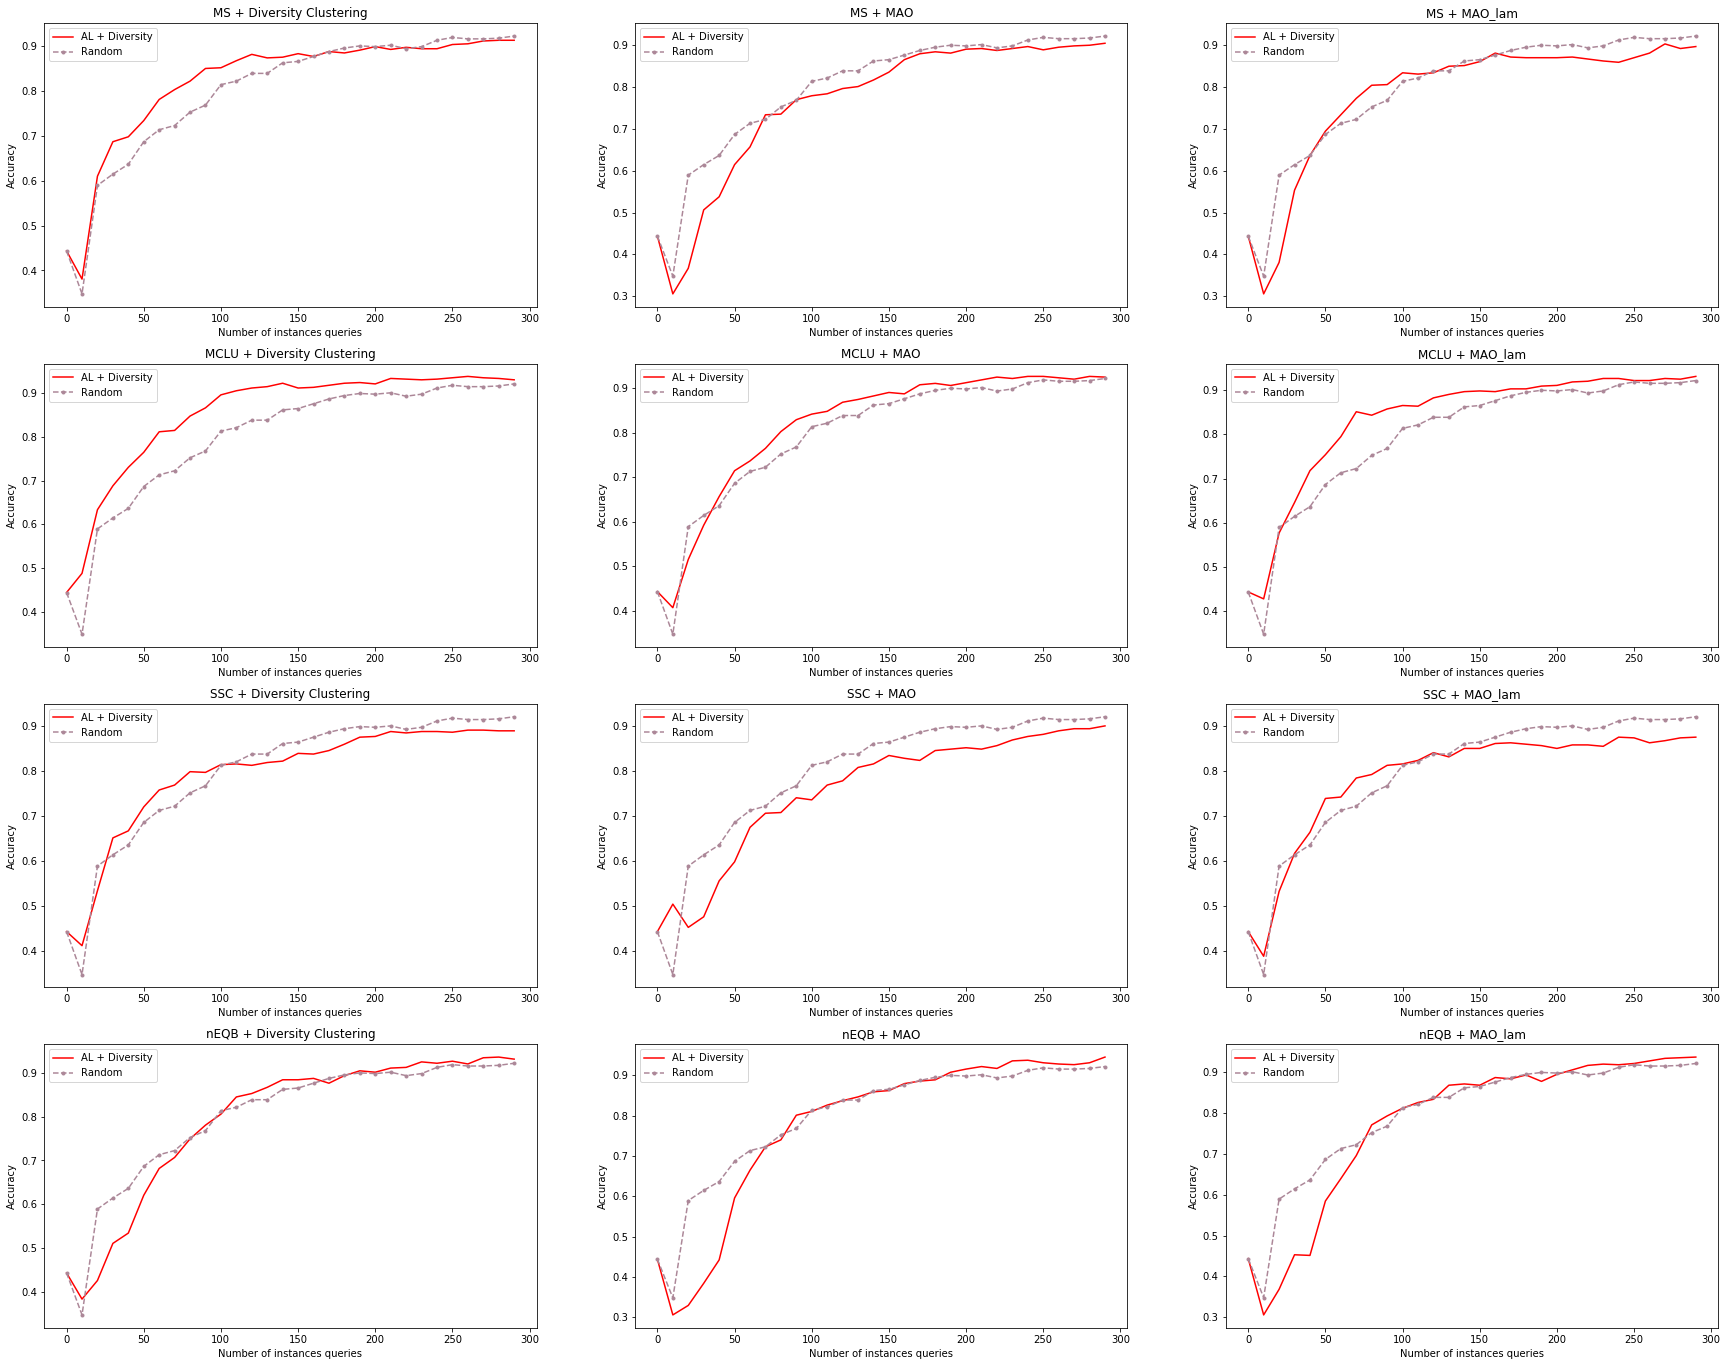

In [7]:

# Graficas (naranja es random)
al = ["MS"]*len(diversity_methods) + ["MCLU"]*len(diversity_methods) + ["SSC"]*len(diversity_methods) + ["nEQB"]*len(diversity_methods)
diversity = ["Diversity Clustering", "MAO", "MAO_lam"]*len(sampling_methods)
x = np.arange(M*n_diver, step = 10)

fig = plt.figure(figsize= (30 , 24))

for i in range(acc.shape[0]):
    fig.add_subplot(4, 3, i + 1)
    plt.plot(x, acc[i,:], "r")
    plt.plot(x, random_accuracy, ".--", color = "#AC8798")
    plt.title(al[i] + " + " + diversity[i])
    plt.legend(("AL + Diversity","Random"))
    plt.ylabel("Accuracy")
    plt.xlabel("Number of instances queries")
    plt.show

# plt.savefig('resultados.png')
